In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Set fontsizes in figures
params = {'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
# plt.rc('text', usetex=True)

# TO DO
# 1) change from len(x) to x.shape[]
# 2) check if all t are correct after changing during work on task i
# 3) export time from lammps
# 4) loop over dataframes: change to enumerate
# 5) change from temperature vary to density for solid Argon

In [2]:
def read_dump(filename):
    """
    Stores data and sorts.
    """
    f_open = open(filename, 'r', newline='\n')
    data = f_open.read()
    f_open.close()

    no_atoms_str = 'ITEM: NUMBER OF ATOMS'
    no_atoms = int(data[data.find(no_atoms_str) +
                        len(no_atoms_str):data.find('ITEM: BOX')])

    str_itm_atm = 'ITEM: ATOMS'

    idx_itm_atm = data.find(str_itm_atm) + len(str_itm_atm) + 1
    idx_end_cols = data.find('\n', idx_itm_atm) - 1

    if '[' in data[idx_itm_atm: idx_end_cols]:
        # If Lammps dump file contains [] from printing an array, it must be
        # removed such that finditer can find proper indices. See below.
        data = data.replace('[', '')
        data = data.replace(']', '')
        idx_itm_atm = data.find(str_itm_atm) + len(str_itm_atm) + 1
        idx_end_cols = data.find('\n', idx_itm_atm) - 1

    # Column names of dataframe
    col_titles = data[idx_itm_atm: idx_end_cols].split(' ')

    dict_list = []

    # Creating dictionary with empty list as values
    data_dict = dict.fromkeys(col_titles, [])

    idx_end_num_data = [match.start()
                        for match in re.finditer('ITEM: TIMESTEP', data[1:])]
    idx_start_num_data = [match.end() + 2
                          for match in re.finditer(col_titles[-1], data)]
    idx_end_num_data.append(-1)  # Including end

    for k in range(len(idx_start_num_data)):
        num_data = data[idx_start_num_data[k]: idx_end_num_data[k]]
        lines = num_data.split('\n')

        for i in range(len(lines)):
            elms = lines[i].split(' ')

            data_dict = dict((j, elms[col_titles.index(j)])
                             for j in col_titles)
            dict_list.append(data_dict)

    dataframe = pd.DataFrame(dict_list, columns=col_titles, dtype=np.float)

    return dataframe

In [3]:
def read_log(name=False):
    if name:
        with open(name, 'r', newline='\n') as f_open:
            data = f_open.read().replace('\r', '')
    else:
        with open('log.lammps', 'r', newline='\n') as f_open:
            data = f_open.read().replace('\r', '')

    # data = data.split()

    idx_col_titles_start = [match.start()
                            for match in re.finditer('Step', data)]
#     idx_end_num = [match.start() for match in re.finditer('Loop', data)]
    idx_end_num = [data.find('Loop', idx_col_titles_start[i]) for i in range(len(idx_col_titles_start))]

    datasets = len(idx_col_titles_start)

    idx_col_titles_end = [
        data.find('\n', idx_col_titles_start[i]) for i in range(datasets)]

    col_titles = data[idx_col_titles_start[0]: idx_col_titles_end[0]].split()
    
    dataframe_list = []  # List of dataframe for all timesteps

    for k in range(datasets):
        dict_list = []  # List of dataframe for current timestep

        num_data = data[idx_col_titles_end[k] + 1: idx_end_num[k] - 1]
        num_data = re.sub(' +', ' ', num_data)

        lines = num_data.split('\n')

        for i in range(len(lines)):
            elms = lines[i].split()

            data_dict = dict((j, elms[col_titles.index(j)])
                             for j in col_titles)

            dict_list.append(data_dict)

        df = pd.DataFrame(dict_list, columns=col_titles, dtype=np.float)

        dataframe_list.append(df)

#     if len(dataframe_list) < 2:
#         return dataframe_list[0]
#     else:
    return dataframe_list

In [83]:
def f(v, T):
    return 4 * np.pi * v**2 * (1 / (2 * np.pi * T))**(3 / 2) * \
        np.exp(-v**2 / (2 * T))


def plot_histogram(v, v_arr, no_tsteps, no_atoms, no_bins, T=2.5):
    for i in range(0, no_tsteps, no_tsteps // 10):
        plt.hist(v_arr[i, :], bins=no_bins, density=True)
        plt.plot(v_arr[i, :], f(v_arr[i, :], T))
        plt.title(f'Time: {0.005 * i:.2f}')
        print(i)
        plt.show()

#     v = np.sort(v)

#     plt.hist(v, bins=no_bins, density=True)
#     plt.plot(v, f(v, T))
#     plt.show()
    
    
def histogram_time_evo(v, v_arr, no_bins):
    hist_list = []
    hist_last = np.histogram(v_arr[-1, :], bins=no_bins)[0]
    hist_last2 = np.sum(hist_last * hist_last)

    t_steps = len(v_arr[:, 0])

    for i in range(t_steps):
        h = np.histogram(v_arr[i, :], bins=no_bins)[0]
        hh = np.sum(h * hist_last)
        hist_list.append(hh / hist_last2)

    x = np.linspace(0, t_steps * 0.005, t_steps)

    plt.plot(x, hist_list, label='Hist. values')
    plt.plot(x, np.ones(t_steps), '--', label='Theoretical')
    plt.legend(loc='best')
    plt.xlabel('Time t')
    plt.ylabel('Histogram values')
    plt.show()

0


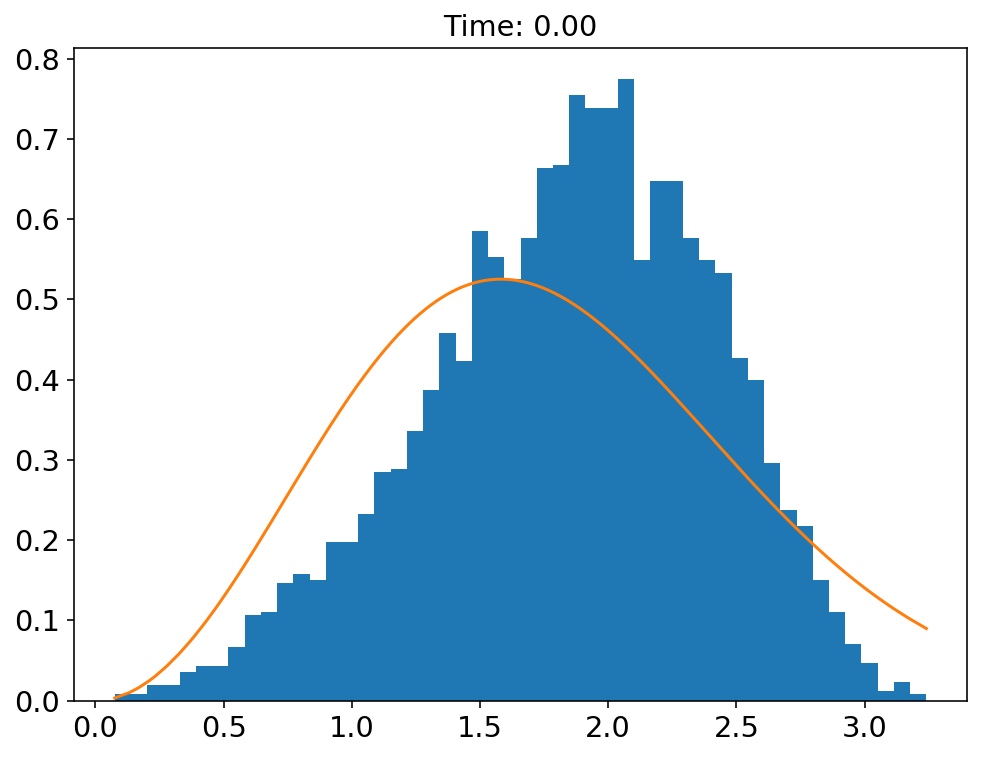

50


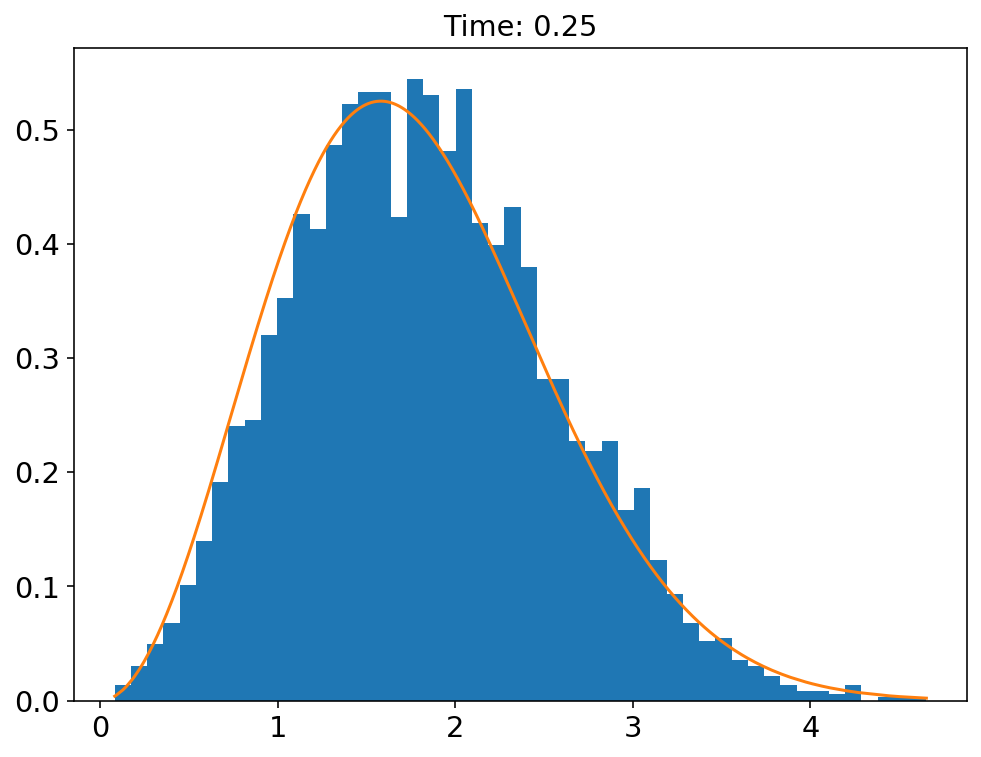

100


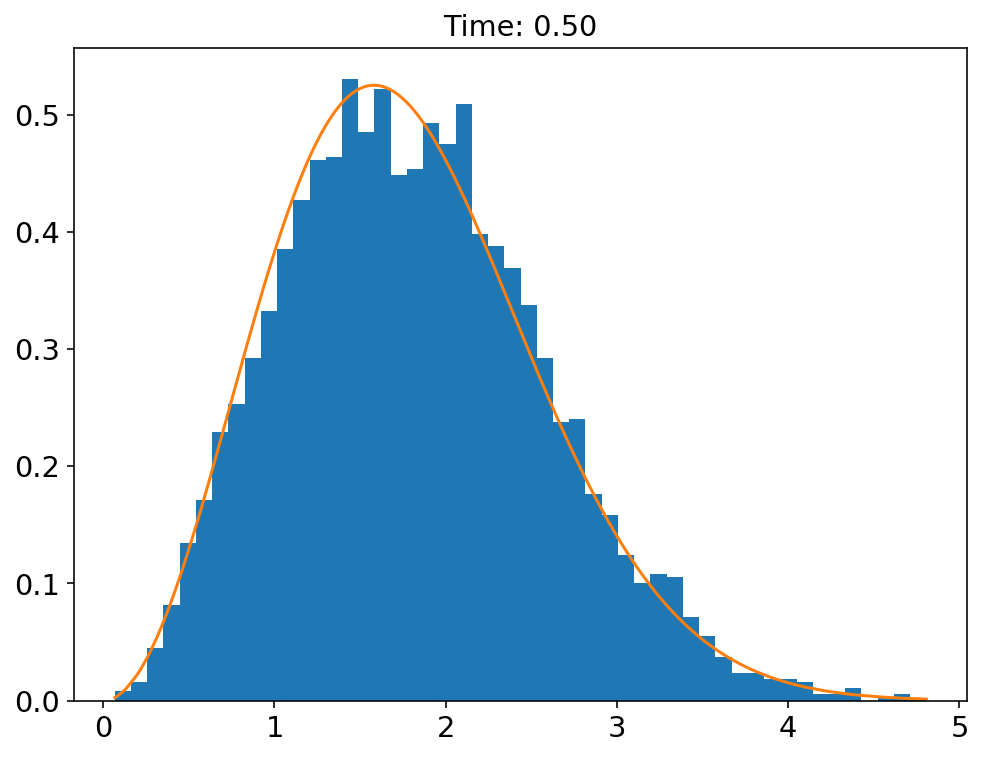

150


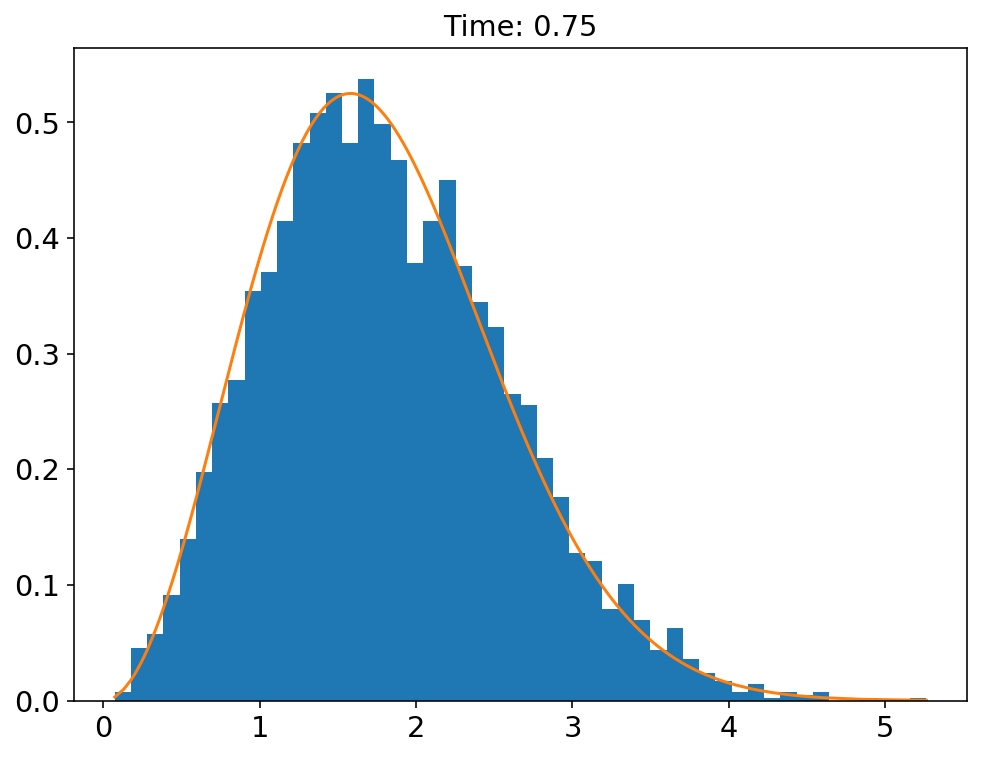

200


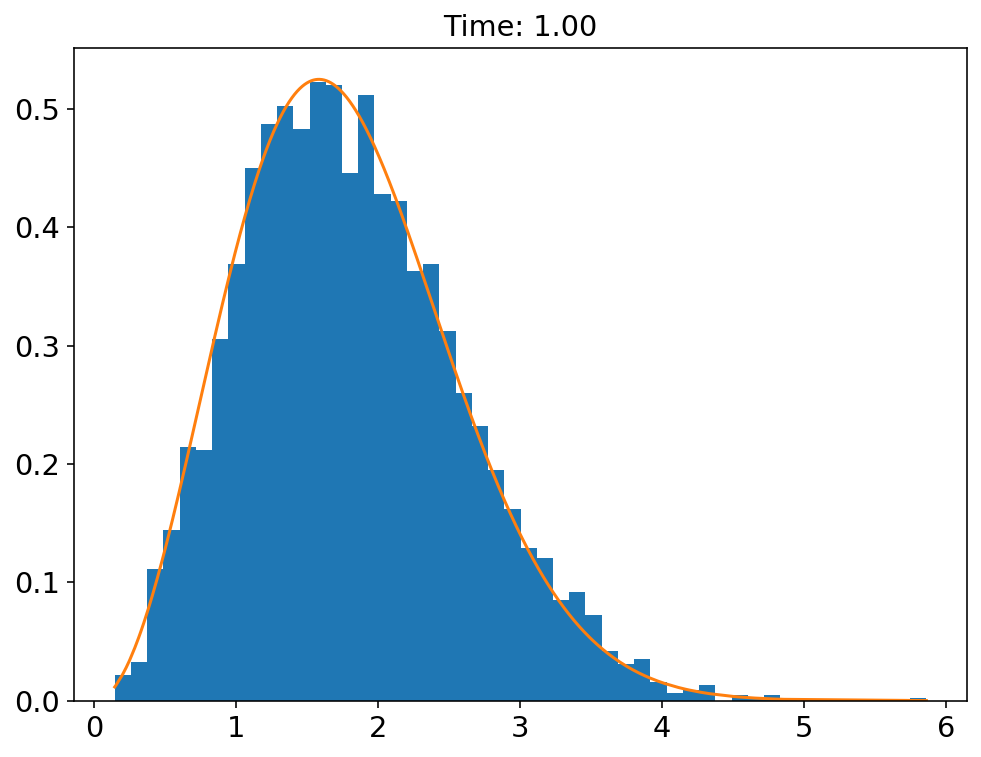

250


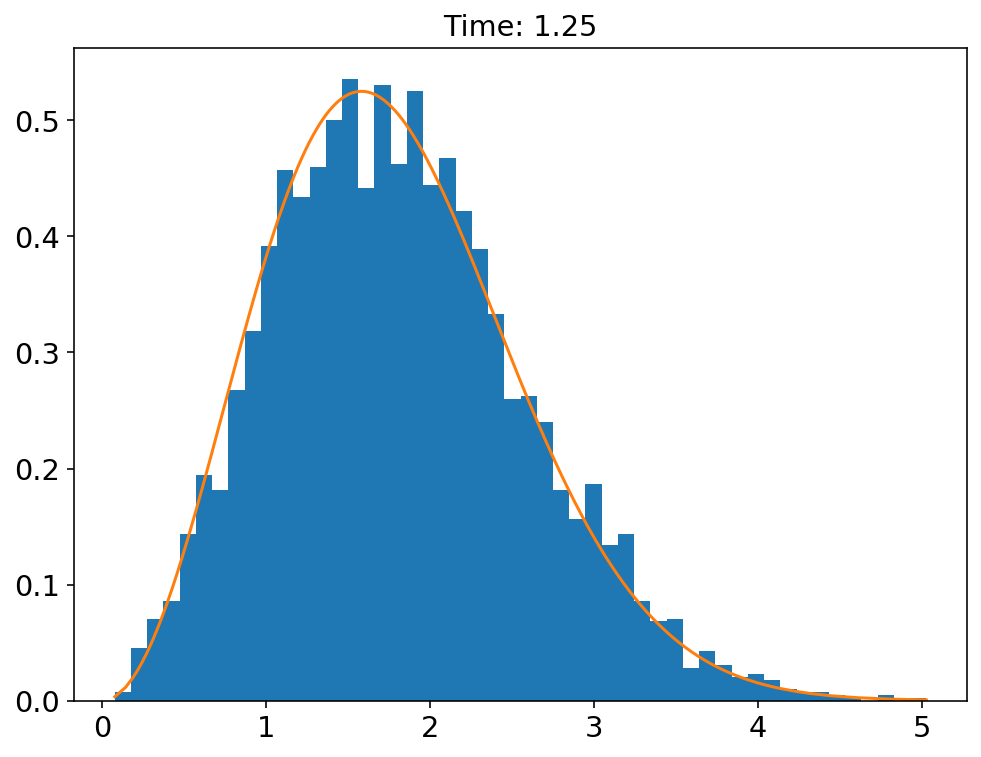

300


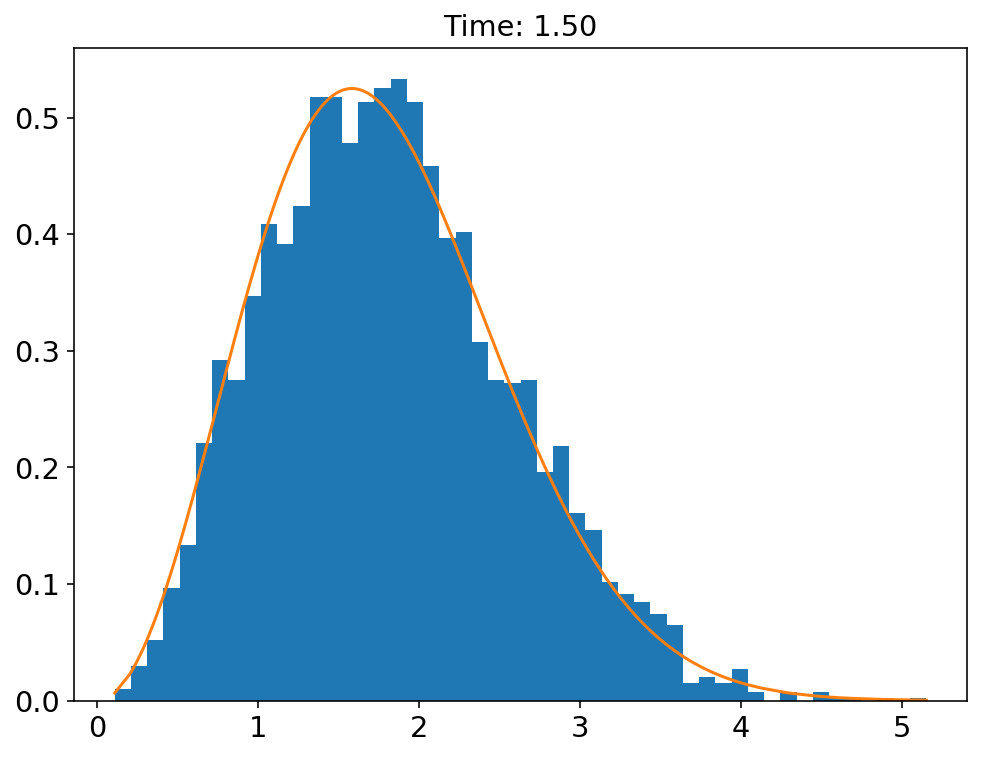

350


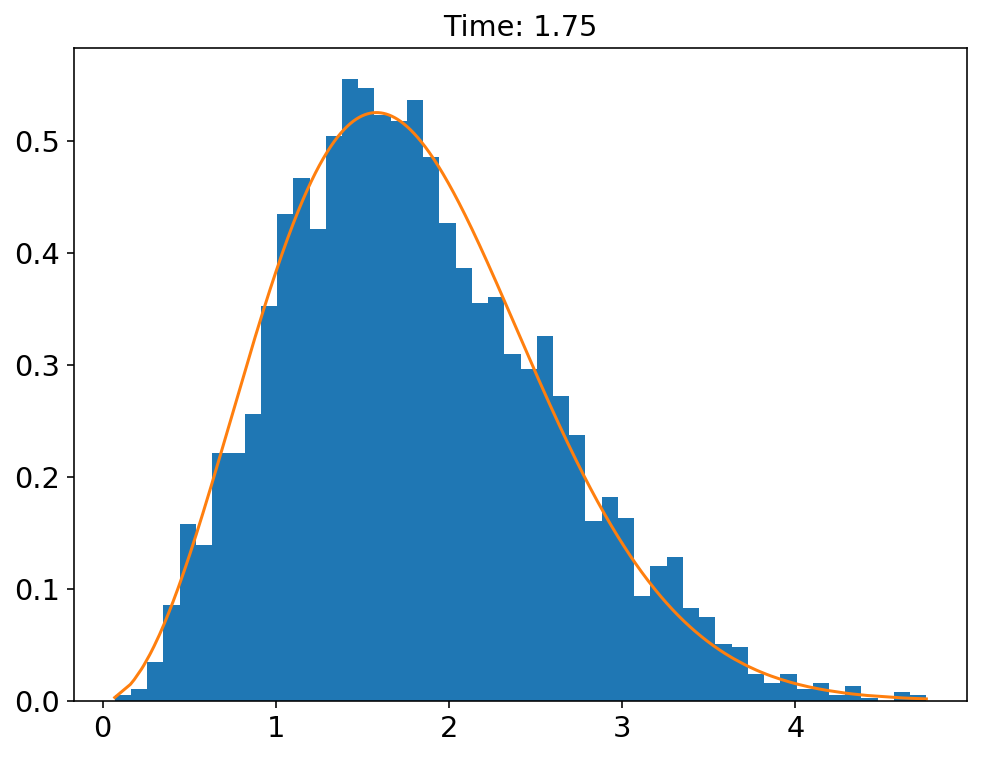

400


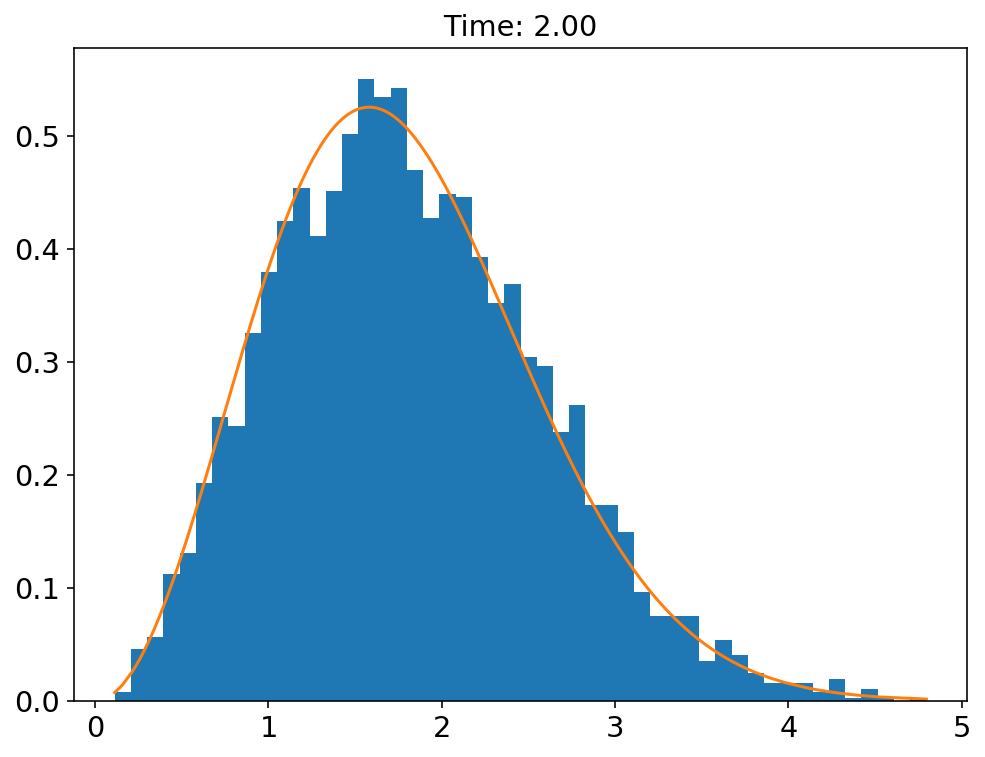

450


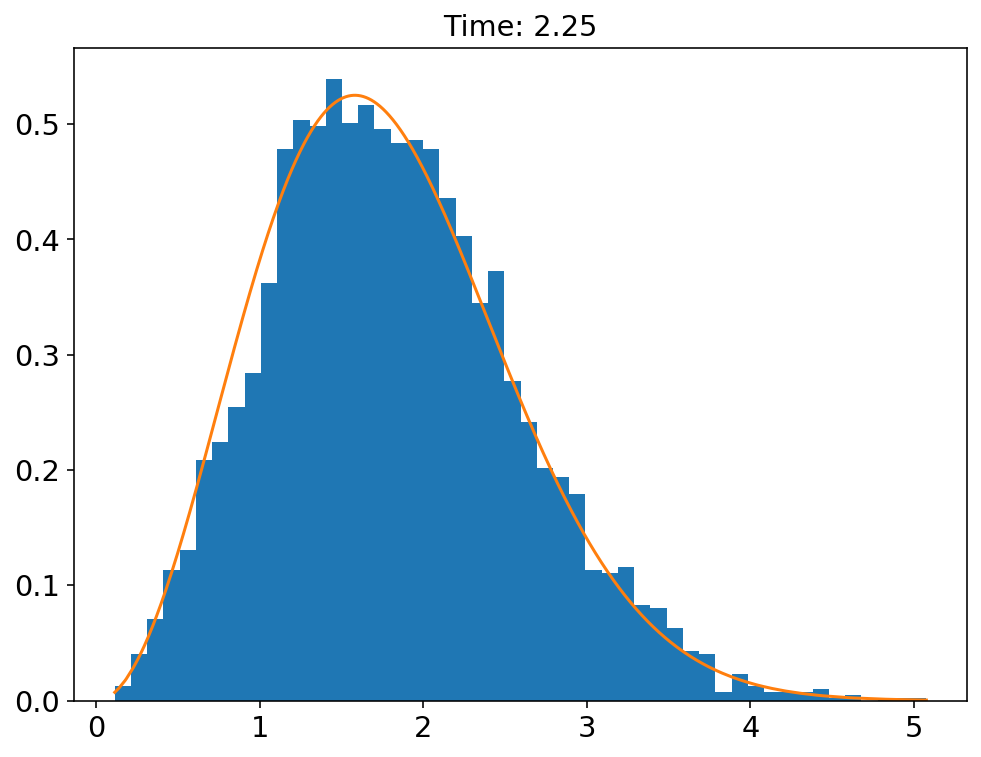

In [84]:
no_tsteps = 500
no_atoms = 4000

df = read_dump('./task_a/dump.task_a')

v = df[['vx', 'vy', 'vz']].to_numpy()
v = np.sqrt(v[:, 0] * v[:, 0] + v[:, 1] * v[:, 1] + v[:, 2] * v[:, 2])

v_arr = np.zeros((no_tsteps, no_atoms))

for i in range(no_tsteps):
    v_arr[i, :] = np.sort(v[i * (no_atoms):(i + 1) * no_atoms])

plot_histogram(v, v_arr, no_tsteps, no_atoms, 50, T=1.25)


From the above we see that the distribution tends to a Boltzmann distribution. Below is the time development of the distribution of velocities.

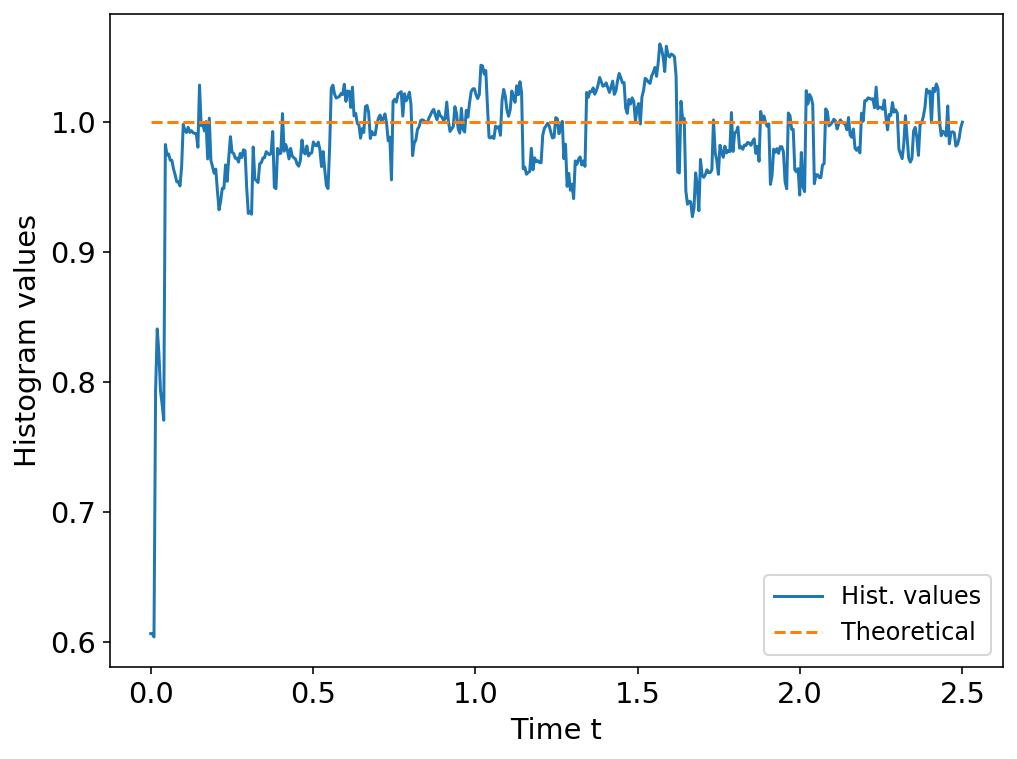

In [85]:
histogram_time_evo(v, v_arr, 50)

By the central limit theorem we observe that the normalized inner product 

$\sum_i h_i(t)h_i(t_n)/\sum_i h_i(t)h_i(t) = 1, \quad t \rightarrow t_n$

if the velocity distribution follows a Boltzmann distribution $\forall$ t. We therefore expect the normalized inner product to be 1. We observe from the above time development that the velocity distribution quickly moves to oscillate about 1.

# Task b)

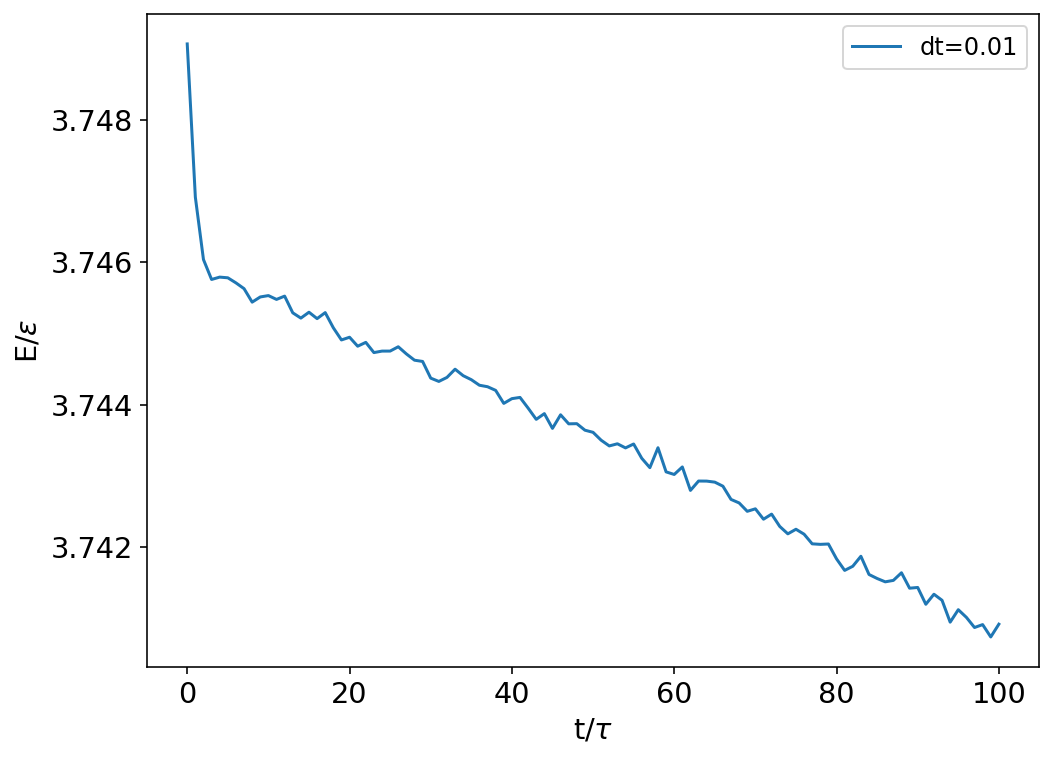

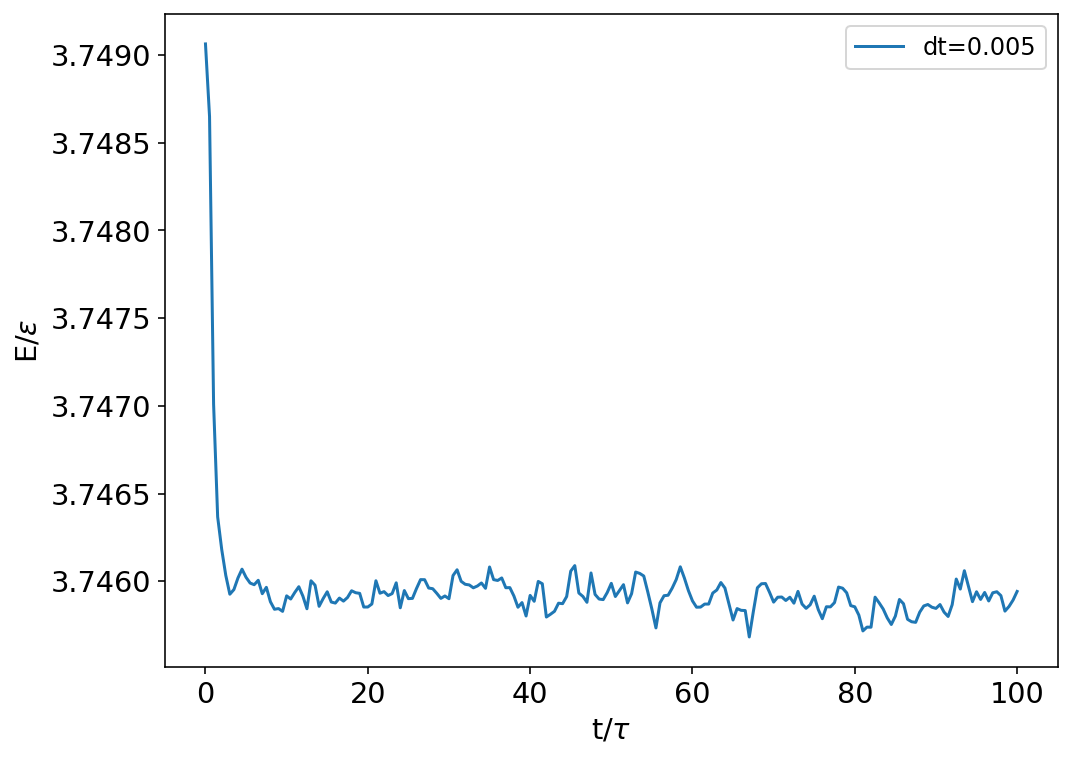

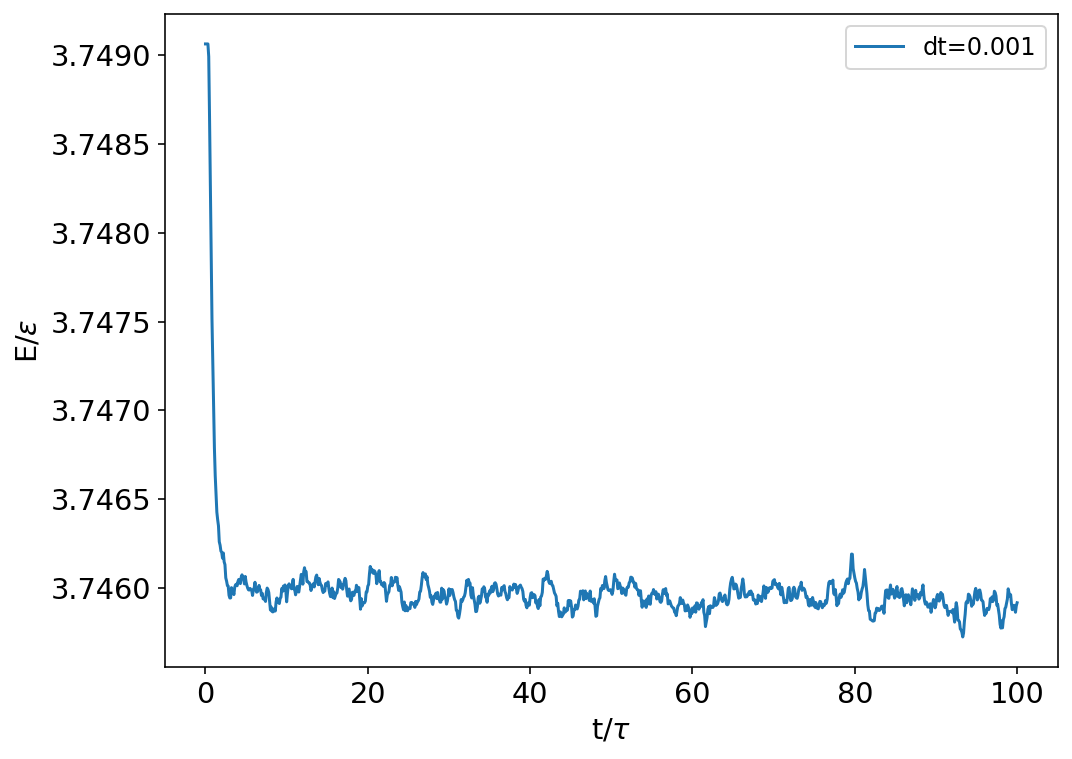

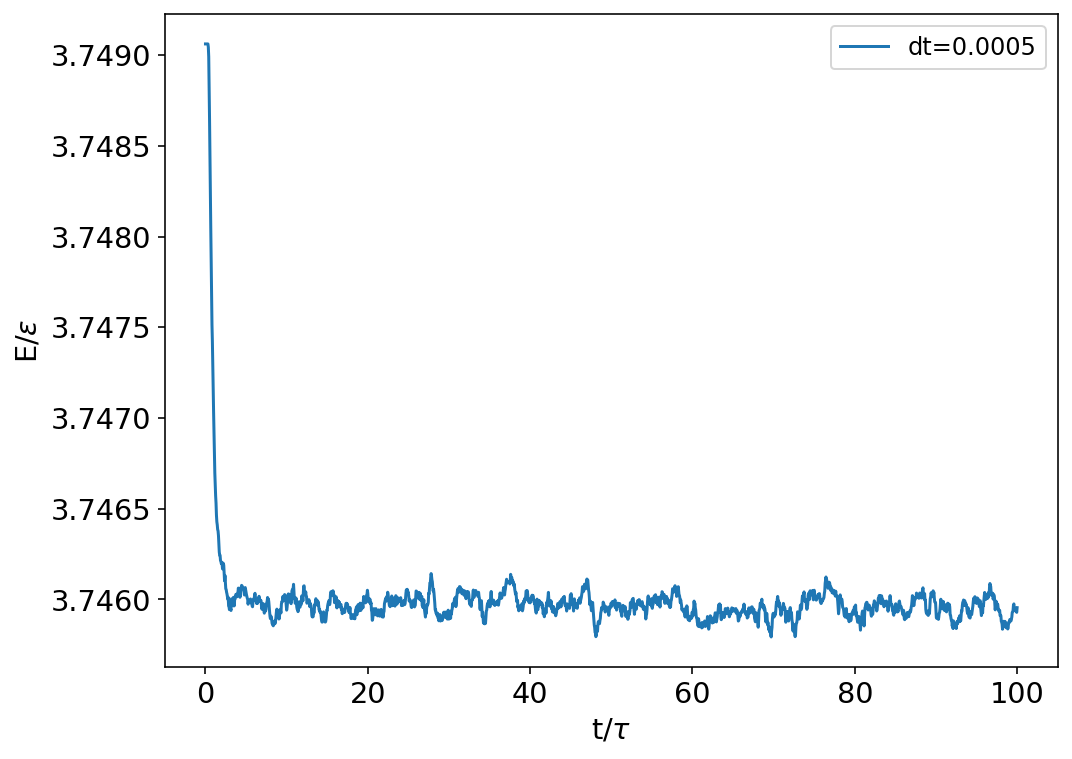

In [86]:
def energy(df):
    if len(df) > 1:
        for i in range(len(df)):
            # Each timestep
            dataframe = df[i]
            E = dataframe[['TotEng']].to_numpy()
            dt = dataframe[['Dt']].to_numpy(dtype=float)[0]
            t = dataframe[['Time']].to_numpy()
            
            plt.plot(t, E[:, 0], label='dt=' + str(dt[0]))
            plt.xlabel(f't/$\\tau$')
            plt.ylabel(f'E/$\\epsilon$')
            plt.legend()
            plt.show()
                    
    else:
        E = df[['TotEng']].to_numpy()
        t = dataframe[['Time']].to_numpy()

        plt.plot(t, E)
        plt.xlabel(f't/$\\tau$')
        plt.ylabel(f'E/$\\epsilon$')
        plt.legend()
        plt.show()

energy(read_log('./task_b/log.lammps'))

From the above figures we see that the energy dissiapates linearly (after a short time) for $dt=0.01$. We do not expect the energy to decrease for a system with the constraints of a micro-canonical ensemble, we consider this to be a result of numerical instability due to high resolution. For the two cases of smaller $dt$ the energy quickly falls before stabilizing, as the atoms move from the initial distribution to a stable state. We see that the fluctuations are smaller and occur more often the more we decrease the timestep, but they follow the same overall trend of the energy fluctuations, which is a result of a finer computational mesh. For a micro-canonical ensemble we would expect the energy to be constant, but due to numerical instability when integrating the energy will fluctuate. 

# Task c)

Average temperature: 2.040
Average temperature: 2.041
Average temperature: 2.041
Average temperature: 2.041


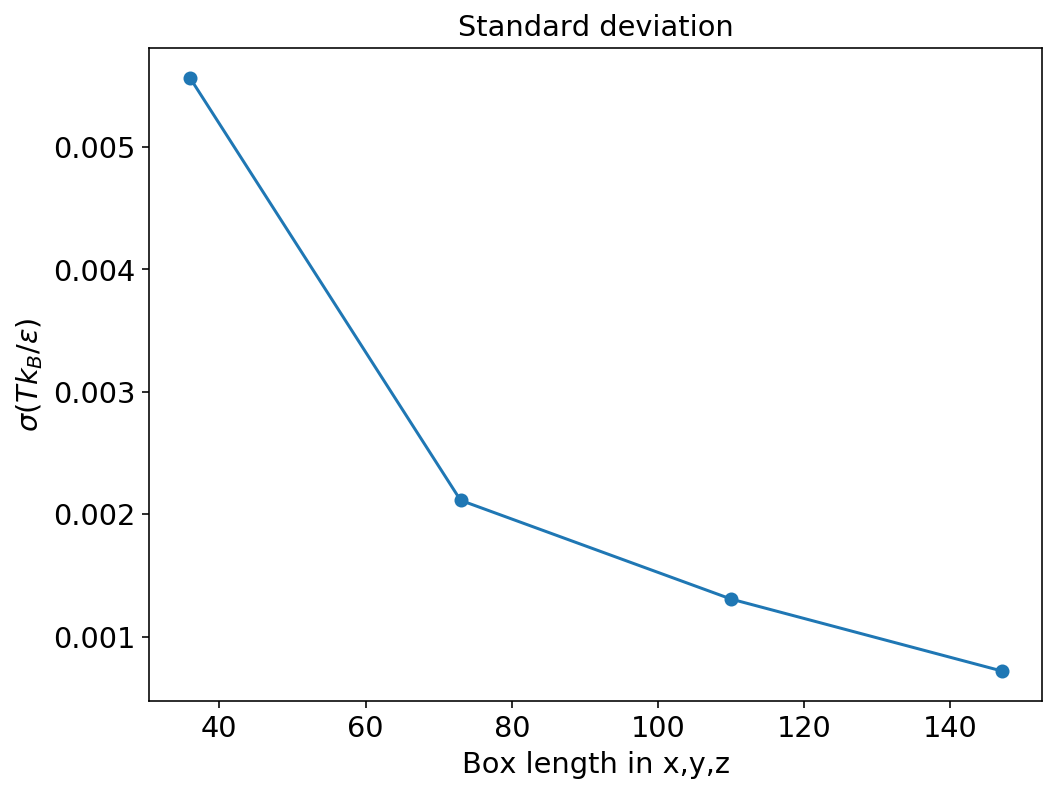

In [87]:
def temperature_variable_box(df):
    std = [] #np.zeros(len(df))
    sysSize = [] #np.zeros_like(std)
    
    for sys_size in range(len(df)):
        # Each timestep
        dataframe = df[sys_size]
        T = dataframe[['Temp']].to_numpy()
        dt = dataframe[['Dt']].to_numpy()[0]
        lx = dataframe[['Lx']].to_numpy(dtype=int)[0,0]
        t = dataframe[['Time']].to_numpy(dtype=int)
        
        T_avg = np.average(T)
        print(f'Average temperature: {T_avg:.3f}')
            
        std.append(np.std(T))
        sysSize.append(lx)
    
    plt.plot(sysSize, std, '-o')
    plt.xlabel(f'Box length in x,y,z')
    plt.ylabel(f'$\\sigma(Tk_B/\\epsilon$)')
    plt.title(f'Standard deviation')
    plt.show()

temperature_variable_box(read_log('./task_c/log.lammps'))

We observe that the average temperature is $\approx 2.04$ after equilibriating the system, this is an increase of 0.04 compared to the initial temperature $2.0$.

From the plot above showing the standard deviation of the temperature we observe that the fluctuations reduces as the system size is increased. Keeping the density constant while changing the system size amounts to changing the number of particles in the system. When increasing the number of particles there is a smaller impact on the system if there is a single, or relatively few, particles moving with a high velocity, which would increase the temperature.

# Task d)


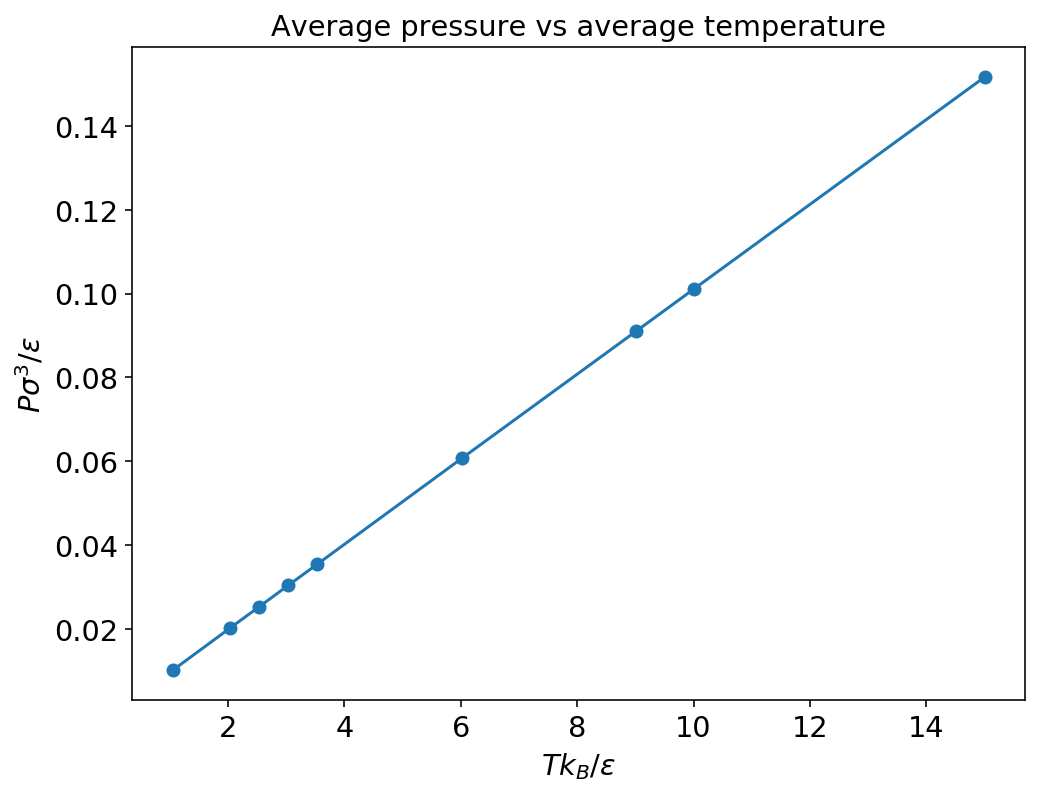

In [88]:
def pressure(df):
    T = np.zeros(len(df))
    P = np.zeros_like(T)
    
    for temp in range(len(df)):
        # Looping over different temperatures
        dataframe = df[temp]
        P[temp] = np.average(dataframe[['Press']].to_numpy())
        T[temp] = np.average(dataframe[['Temp']].to_numpy())

    plt.plot(T, P, '-o')
    plt.xlabel(f'$Tk_B$/$\\epsilon$')
    plt.ylabel(f'$P\\sigma^3$/$\\epsilon$')
    plt.title(f'Average pressure vs average temperature')
    plt.show()
    
pressure(read_log('./task_d/log.lammps'))

From the figure above we see that the pressure increases linearly as we increase the temperature. Since we are keeping the system size, energy and number of particles constant we expect a linear depence on the temperature and pressure.

# Task e)

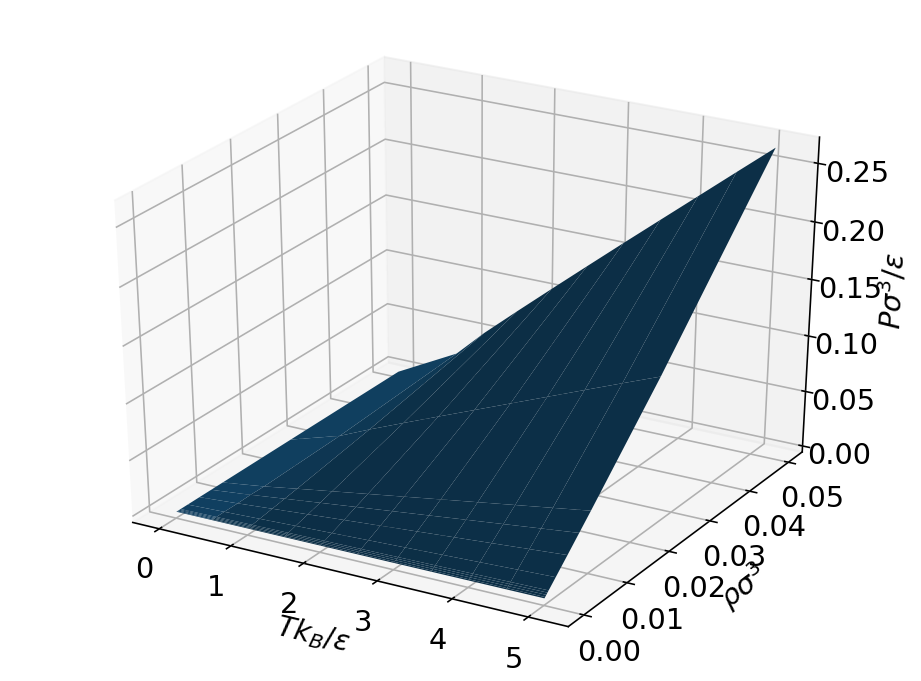

In [89]:
def density(df):
    no_temps = 11
    no_dens = no_temps
    
    P = np.zeros((no_temps, no_dens))
    T = np.zeros_like(P)
    rho = np.zeros_like(P) 
        
    for i in range(no_temps):
        # For one temp there are 11 densities
        start = i * no_temps
        stop = (i + 1) * no_temps
        dataframe = df[start:stop] # Choose densities for current temp
        for j in range(no_dens):
            dataframe_slice = dataframe[j]
            T[i, j] = np.mean(dataframe_slice[['Temp']].to_numpy())
            rho[i, j] = np.mean(dataframe_slice[['Density']].to_numpy())
            P[i, j] = np.mean(dataframe_slice[['Press']].to_numpy())

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, rho, P)
    ax.set_xlabel(f'$Tk_B/\\epsilon$')
    ax.set_ylabel(f'$\\rho \\sigma^3$')
    ax.set_zlabel(f'$P\\sigma^3/\\epsilon$')
    plt.show()
    
density(read_log('./task_e/log.lammps'))

In the above figure we see that the pressure increases as both the temperature and density increases. The average pressure is given by

\begin{equation}
P = \rho k_B T + \frac{3}{2}\sum_{i < j} \mathbf{F}_{ij} \cdot \mathbf{r}_{ij},
\end{equation}

which tells us we would expect a linear dependence on the pressure, temperature and density. 

# Task f)

In [4]:
def displacement(df, t_lin=0):
    D = []
    msd = []
    T = []
    t = []
    
    for i, dataframe in enumerate(df):
        new_df = dataframe[dataframe['Time'] > t_lin]
        
        t.append(new_df[['Time']].to_numpy()) # Same for each run
        T.append(np.average((new_df[['Temp']].to_numpy())))
        msd.append(new_df[['c_myMSD[4]']].to_numpy()[:, 0])
    
    return msd, T, t

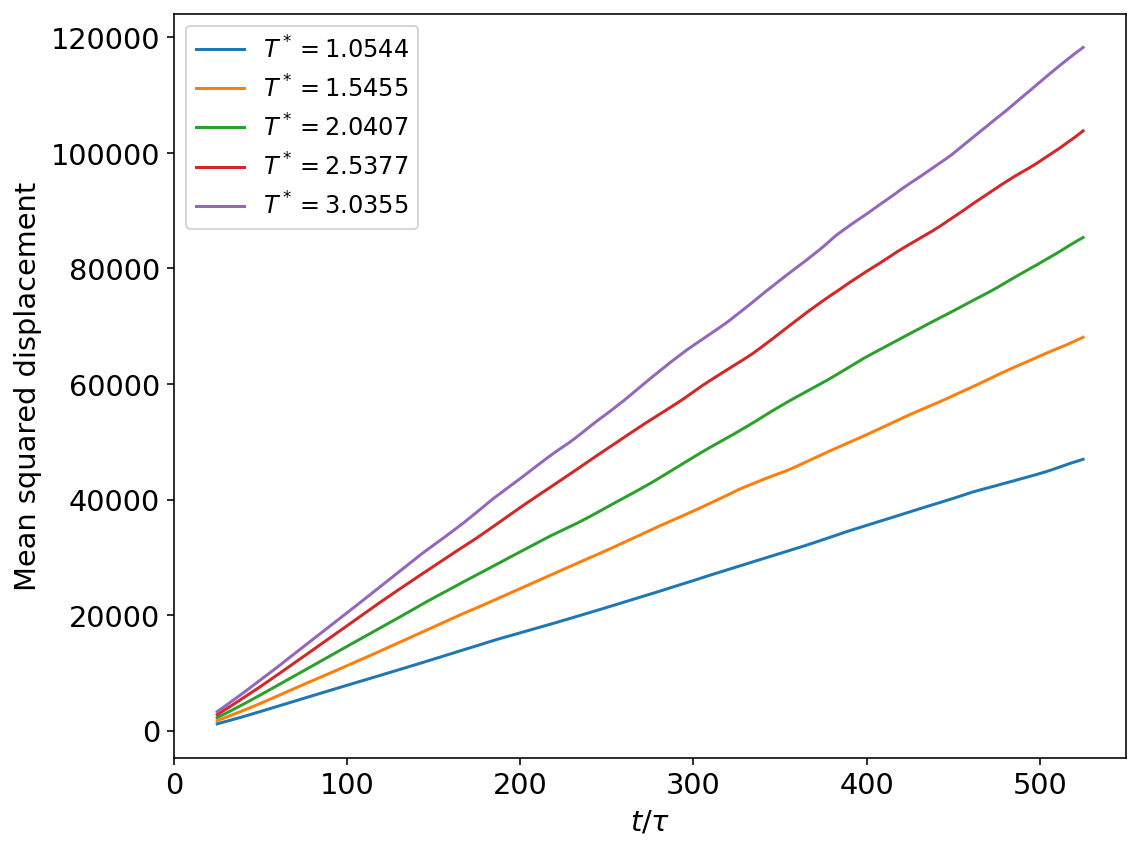

In [92]:
msd, T, t = displacement(read_log('./task_f/log.lammps'))
      
for i in range(len(msd)):
    plt.plot(t[i], msd[i])
    plt.xlabel(f'$t / \\tau$')
    plt.ylabel('Mean squared displacement')
plt.legend([f'$T^* = {temp:.4f}$' for temp in T])
plt.tight_layout(True)
plt.show()

    


    

From the above we see that the msd is approximately linear for the whole time development. For good measure we consider the msd from $t/\tau > 100$ to get a better approximation of the diffusion constant.

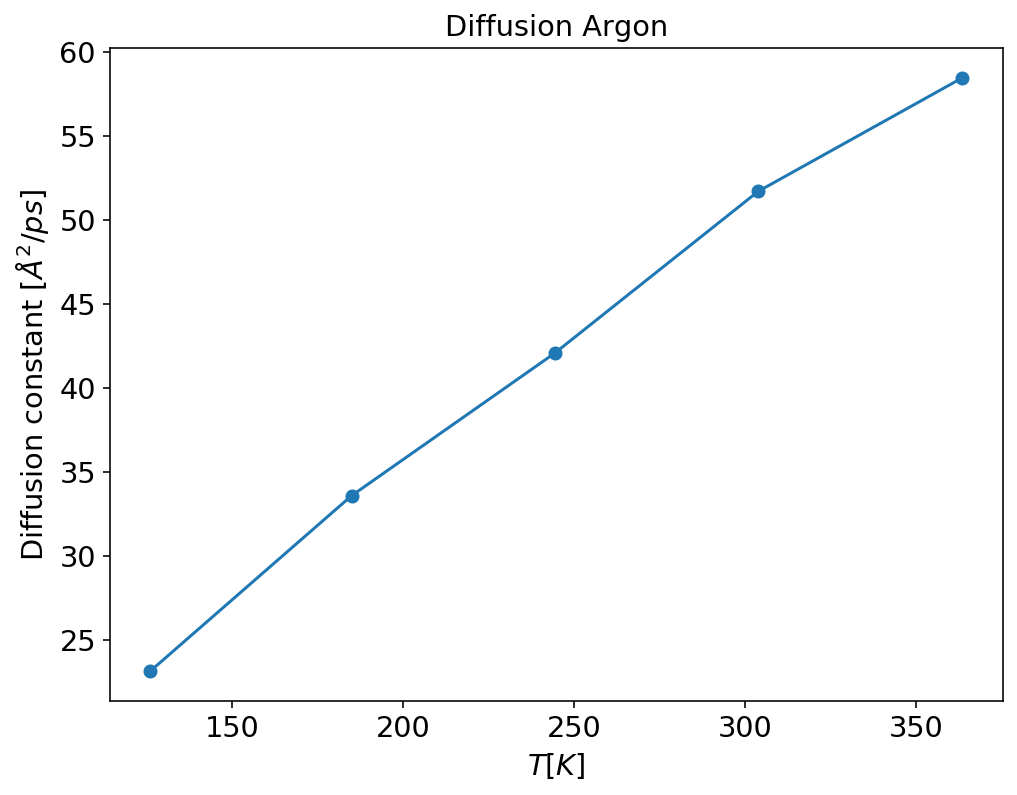

In [33]:
t_lin = 1

msd, T, t = displacement(read_log('./task_f/log.lammps'), t_lin=t_lin)

D = np.zeros(len(msd))
for i in range(len(msd)):
    clf = LinearRegression(fit_intercept=False).fit(t[i] * 2.1569, msd[i][:, np.newaxis] * 3.405)
    D[i] = clf.coef_[0, 0] / 6
    
# t* = t / tau = t * sqrt(eps/m*sigma**2) = t = t* * sqrt(m*sigma**2 / eps) = t* * 3.405Å * sqrt(m)

plt.plot(np.array(T) * 119.74, D, '-o')
plt.title('Diffusion Argon')
plt.xlabel(f'$T [K]$')
plt.ylabel('Diffusion constant $[Å^2 / ps]$')
plt.show()


We see that the diffusion constant and the mean squared displacement increases with temperature. When the temperature increases, so does the velocities of the particles, which again means the mean squared displacement increases. 

# Task g)


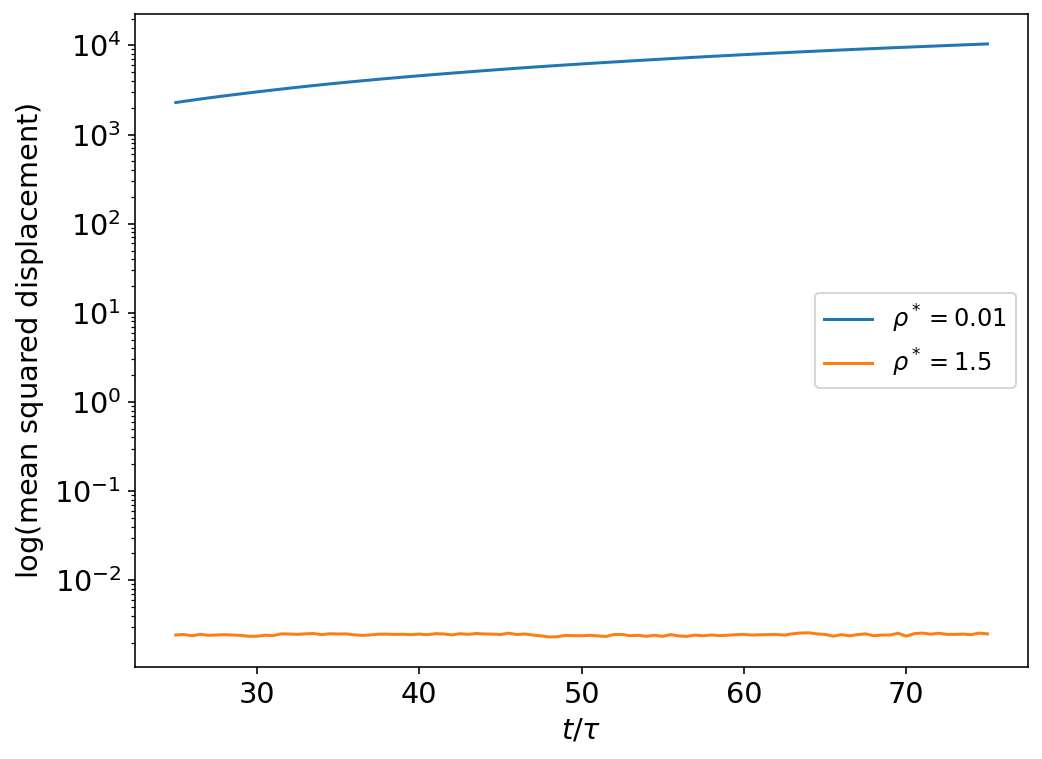

In [94]:
def rdf(filename):
    with open(filename, 'r', newline='\n') as f_open:
        data = f_open.read()

    data = re.sub(' +', ' ', data)

    lines = data.split('\n')
    lines = lines[4:-1]

    rdf_arr = np.zeros((len(lines), 2))

    for i, line in enumerate(lines):
        temp = np.fromstring(line, dtype=float, sep=' ')
       
        rdf_arr[i, :] = temp[2:]

    r = rdf_arr[:, 1]
    g = rdf_arr[:, 0]
    
    return r, g

msd, T, t = displacement(read_log('./task_g/log.lammps'))

for i in range(len(msd)):
    plt.semilogy(t[i], msd[i])
plt.xlabel(f'$t/\\tau$')
plt.ylabel(f'$\\log$(mean squared displacement)')
plt.legend(['$\\rho^*=0.01$', '$\\rho^*=1.5$'])
plt.show()

Above we see that for density $\rho^*=0.01$ that the msd is increasing with time, hence the particles in the fluid are moving. For $\rho^*=1.5$ we observe that the msd is small, which is what we would expect from a solid.

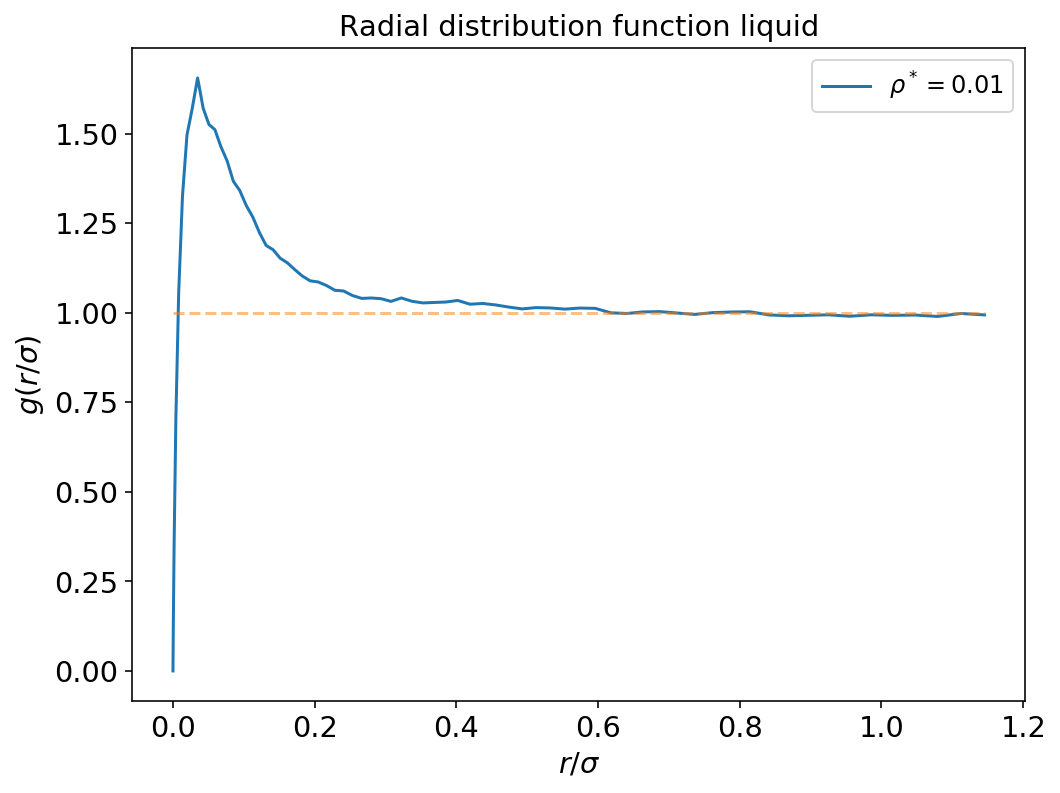

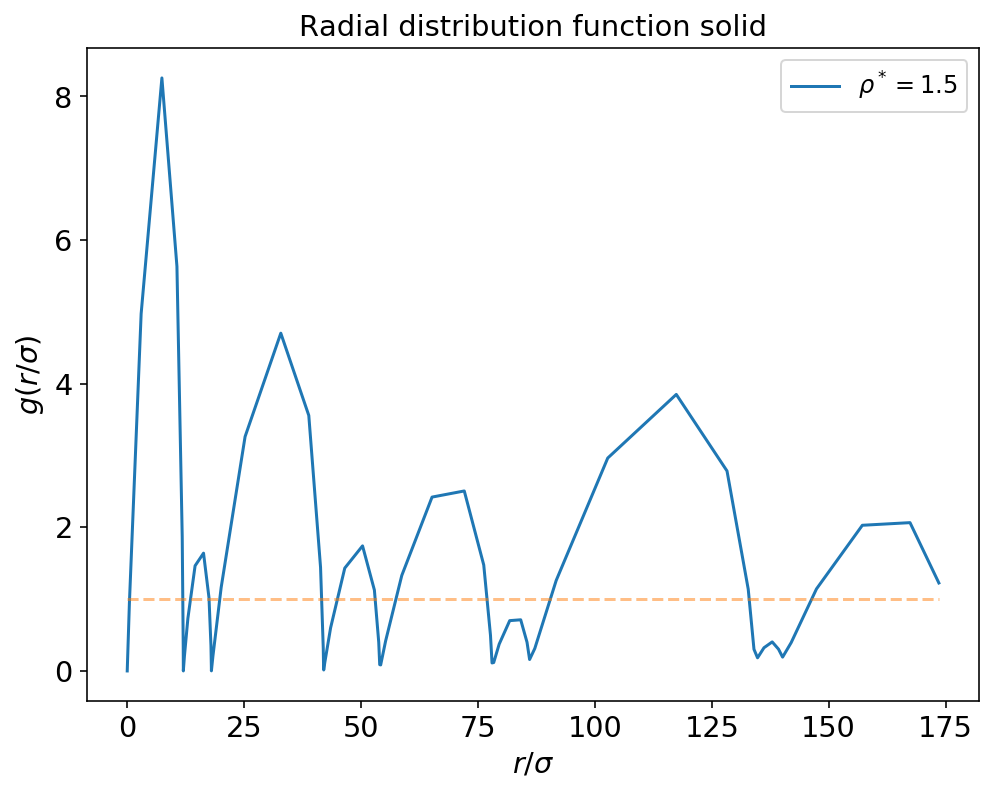

In [95]:

r, g = rdf('./task_g/time_avg_rdf_rho0.01.txt')
r_2, g_2 = rdf('./task_g/time_avg_rdf_rho1.5.txt')

plt.plot(r, g, label=f'$\\rho^*= 0.01$')
plt.plot(r, np.ones(len(r)), '--', alpha=0.5)
plt.xlabel('$r / \\sigma$')
plt.ylabel('$g(r/\\sigma)$')
plt.title('Radial distribution function liquid')
plt.legend()
plt.show()

plt.plot(r_2, g_2, label=f'$\\rho^* = 1.5$')
plt.plot(r_2, np.ones(len(r_2)), '--', alpha=0.5)
plt.xlabel('$r / \\sigma$')
plt.ylabel('$g(r/\\sigma)$')
plt.title('Radial distribution function solid')
plt.legend()
plt.show()

The figure above shows the radial distribution function (rdf) for Argon in a liquid and solid state. For the liquid state we observe that the probability of finding other particls reduces as the radius of the shell surroundinga given particle increases. For a solid we expect to observe sharp peaks at given radii with a constant distance, but due to small movements in the solid we observe somewhat smoothed peaks. For a crystal we would expect the rdf to have infinite peaks at given radii due to there being no movement in the system, i.e. the probability of finding a particle at a given radius r is infinite due to the perfect structure.

# Task h)

Berendsen thermostat scales the velocities and therefore the temperature. Changing the temperature corresponds to changing the energy. Changing the energy in a system where the number of particles N, volume V and energy E should be constant means there is a violation of the micro canonical ensemble.

# Task i)

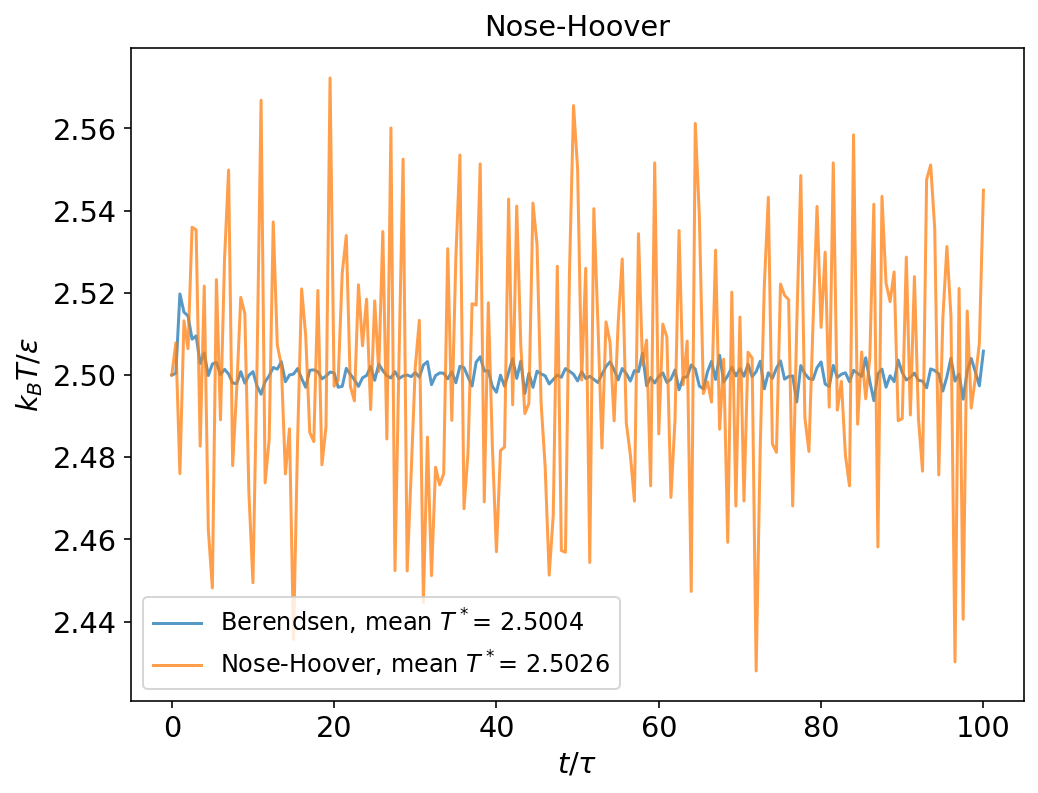

In [96]:
def temperature_thermostat(df):
    titles = ['Berendsen', 'Nose-Hoover']
    for i, dataframe in enumerate(df):
        T = dataframe[['Temp']].to_numpy()
        t = dataframe[['Time']].to_numpy()
    
    return T, t
    

T_b, t_b = temperature_thermostat(read_log('./task_i/log.berendsen'))
T, t = temperature_thermostat(read_log('./task_i/log.nose-hoover'))

plt.plot(t_b, T_b, label=f'Berendsen, mean $T^*$= {np.average(T_b):.4f}', alpha=0.75)
plt.xlabel('$t/\\tau$')
plt.ylabel('$k_B T / \epsilon$')
# plt.legend([f'Mean $T^*$= {np.average(T_b):.4f}'])

plt.plot(t, T, label=f'Nose-Hoover, mean $T^*$= {np.average(T):.4f}', alpha=0.75)
plt.xlabel('$t/\\tau$')
plt.ylabel('$k_B T / \epsilon$')
plt.legend()
plt.title('Nose-Hoover')
plt.show()

r, g = rdf('./task_i/time_avg_rdf_berendsen.txt')
r_2, g_2 = rdf('./task_i/time_avg_rdf_nose-hoover.txt')


msd_b, T_b, t_b = displacement(read_log('./task_i/log.berendsen'))
msd, T, t = displacement(read_log('./task_i/log.nose-hoover'))

D_b = np.zeros(len(msd))
for i in range(len(msd)):
    clf = LinearRegression(fit_intercept=False).fit(t[i], msd_b[i][:, np.newaxis])
    D_b[i] = clf.coef_[0, 0] / 6
    
D = np.zeros(len(msd))
for i in range(len(msd)):
    clf = LinearRegression(fit_intercept=False).fit(t[i], msd[i][:, np.newaxis])
    D[i] = clf.coef_[0, 0] / 6

We see that the temperature fluctuations for Nose-Hoover are larger than for Berendsen. The average temperature for Berendsen is slightly closer (0.0026) to the initial temperature. 

# Task j)

Stillinger-Weber potential:

\begin{equation*}
E = \sum_i \sum_j V_2(r_{ij}) + \sum_i \sum_j \sum_k V_3(r_{ij}, r_{ik}, \theta_{ijk}),
\end{equation*}

where 

\begin{equation*}
V_2(r_{ij} = A_{ij}\epsilon_{ij}\left[B_{ij}\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{p_{ij}} - \left(\frac{\sigma_{ij}}{r_{ij}}\right)^{q_{ij}}\right] \exp\left(\frac{\sigma_{ij}}{r_{ij} - a_{ij}\sigma_{ij}}\right)
\end{equation*}

and

\begin{equation*}
V_3(r_{ij}, r_{ik}, \theta_{ijk}) = \lambda_{ijk}\epsilon_{ijk}\left[\cos\theta_{ijk} - \cos\theta_{ijk,0}\right]^2 \exp\left(\frac{\gamma_{ij}\sigma_{ij}}{r_{ij} - a_{ij}\sigma_{ij}}\right)\exp\left(\frac{\gamma_{ik}\sigma_{ik}}{r_{ij} - a_{ik}\sigma_{ik}}\right).
\end{equation*}

We observe that $V_2$ is similar to Lennard-Jones potential, 

\begin{equation*}
U(r) = 4\epsilon\left(\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right),
\end{equation*}

where the terms in the square brackets of $V_2$ and $U(r)$ both handle pairwise interactions, but they differ in exponenent of both terms. There is an added weight $B_{ij}$ of the first term in $V_2$, which scales the attraction between particles. $V_3$ handles the interaction between three particles, considering the angle between them as well as the distance, considering this for a two-particle interaction would cause the term to be zero, as the cosine part would be 0.

# Task k)

## Solid phase
![SegmentLocal](task_j/solid2.gif "Si solid")

## Liquid phase
![SegmentLocal](task_j/liquid2.gif "Si liquid")

## Gas phase
![SegmentLocal](task_j/gas2.gif "Si gas")

# Task l)

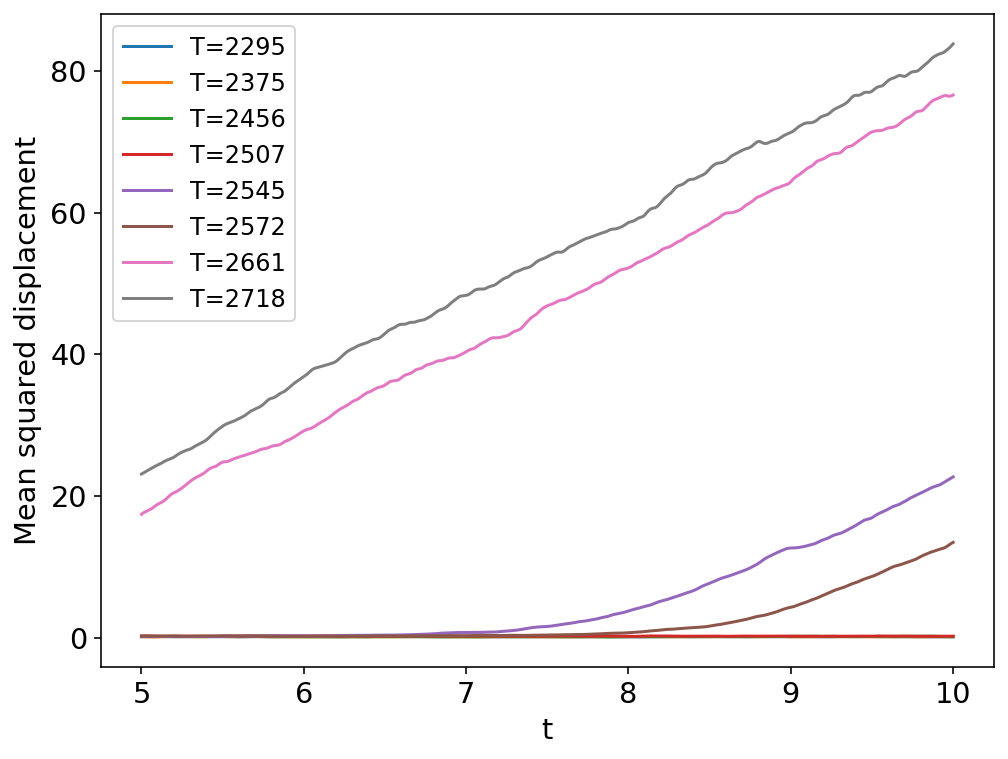

In [5]:
msd, T, t = displacement(read_log('./task_l/log.lammps'))#, t_lin=9)

for i, temp in enumerate(T):
    plt.plot(t[i], msd[i], label=f'T={temp:.0f}')
plt.xlabel('t')
plt.ylabel('Mean squared displacement')
plt.legend()
plt.show()

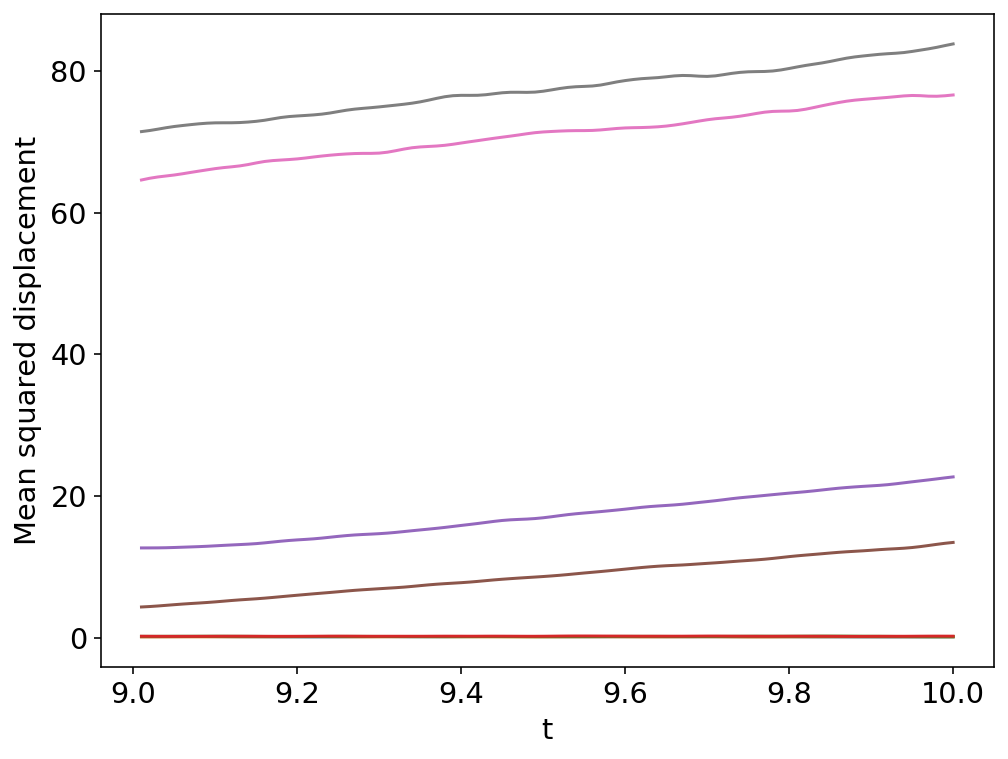

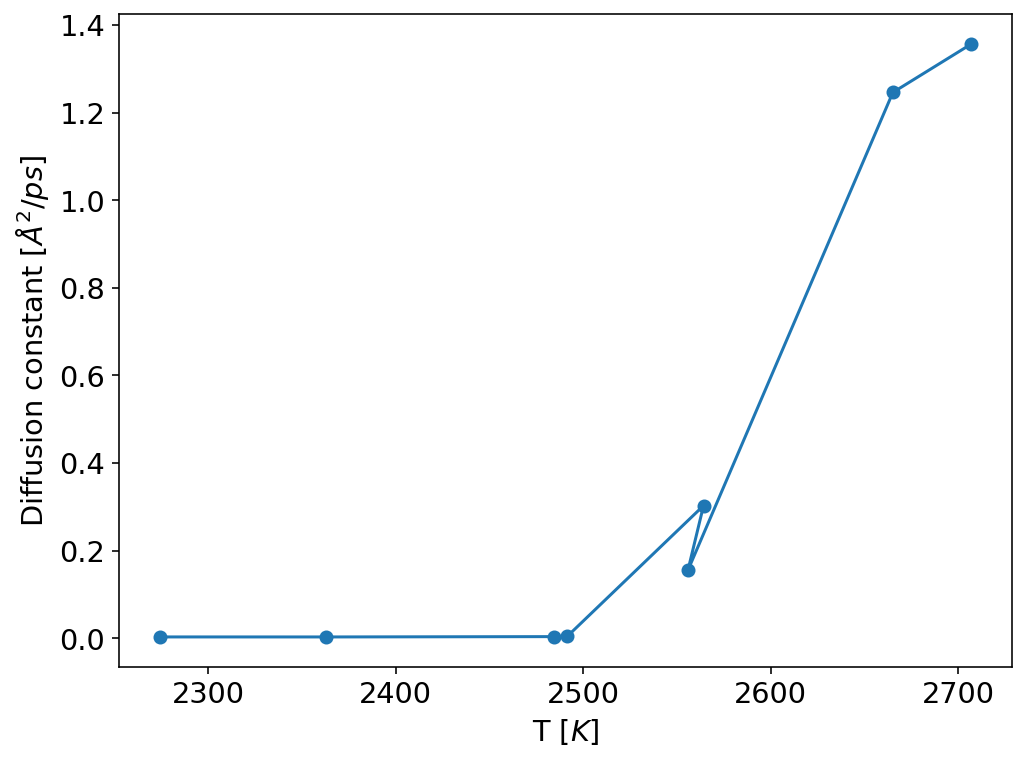

In [19]:
msd, T, t = displacement(read_log('./task_l/log.lammps'), t_lin=9)

for i, temp in enumerate(T):
    plt.plot(t[i], msd[i], label=f'T={temp:.0f}')
plt.xlabel('t')
plt.ylabel('Mean squared displacement')
plt.show()

D = np.zeros(len(msd))
for i in range(len(msd)):
    clf = LinearRegression(fit_intercept=False).fit(t[i], msd[i][:, np.newaxis])
    D[i] = clf.coef_[0, 0] / 6

plt.plot(T, D, '-o')
plt.xlabel(f'T $[K]$')
plt.ylabel('Diffusion constant $[Å^2 / ps]$')
plt.show()


We observe that the melting point is approximately $T_{melt}\approx 2500$ K. At standard condition for pressure we would expect the melting temperature to be $1687$ K. 

# Task m)

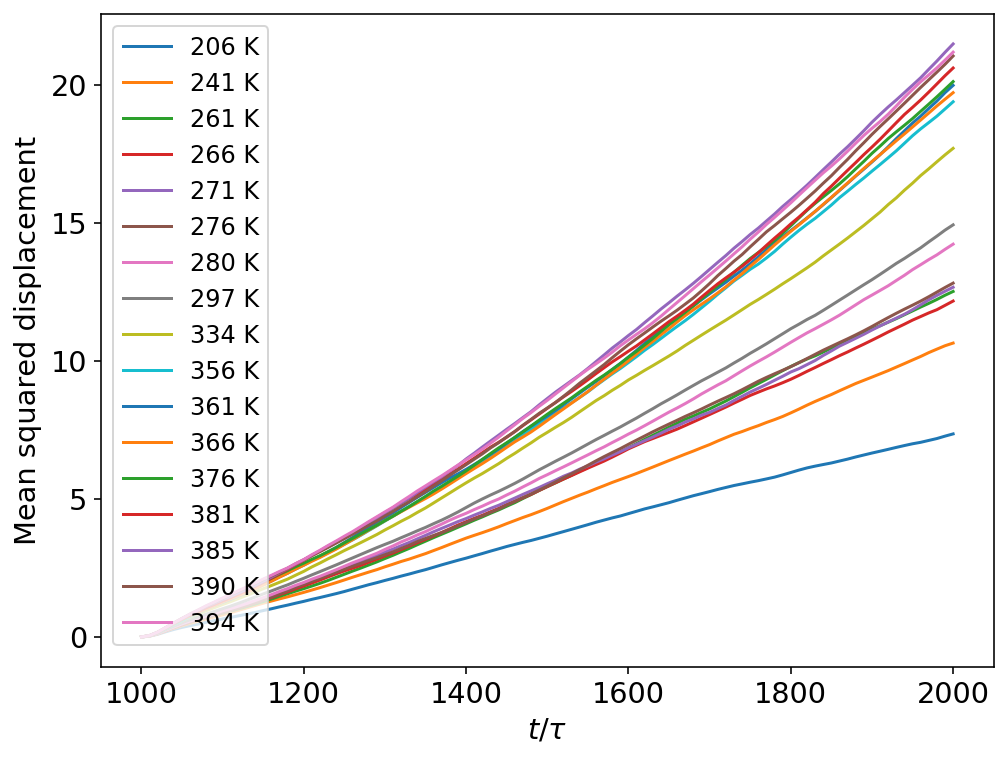

In [99]:
msd, T, t = displacement(read_log('./task_m/msd/log.lammps'))

for i in range(len(msd)):
    plt.plot(t[i], msd[i], label=f'{np.average(T[i]):.0f} K')
plt.xlabel(f'$t/\\tau$')
plt.ylabel(f'Mean squared displacement')
plt.legend(loc='upper left')
plt.show()

From the figure above we see taht for $t/\tau > 1800$ the msd is approximately linear.

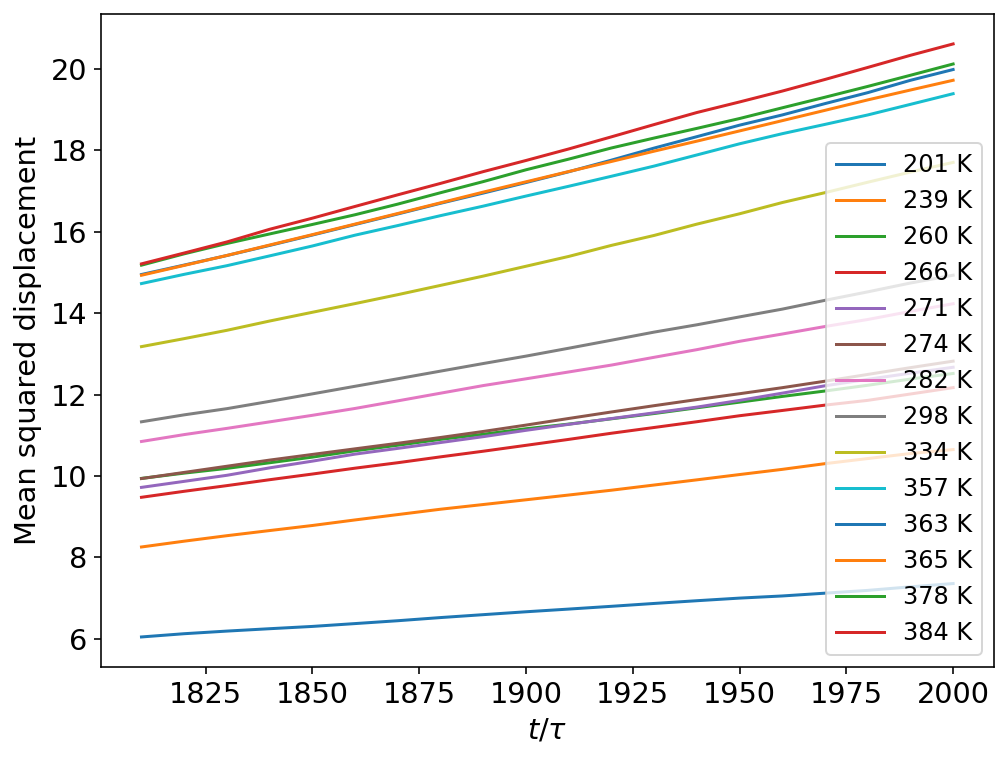

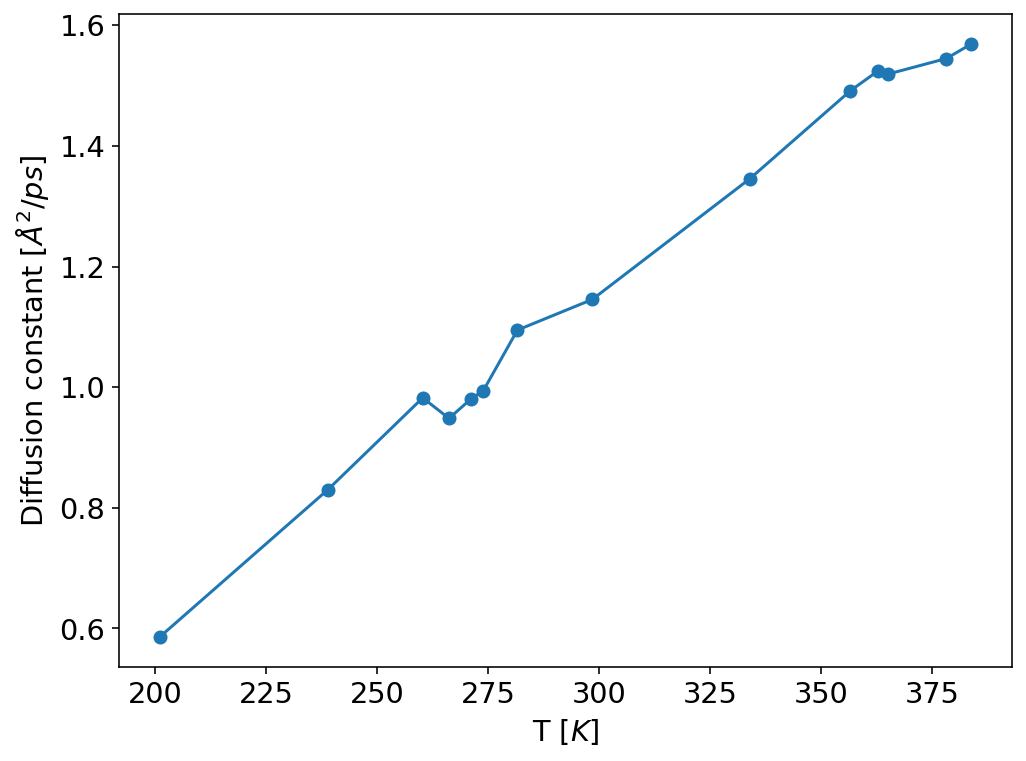

In [18]:
msd, T, t = displacement(read_log('./task_m/msd/log.lammps'), t_lin=1800)

for i in range(len(msd)):
    plt.plot(t[i], msd[i], label=f'{np.average(T[i]):.0f} K')
plt.xlabel(f'$t/\\tau$')
plt.ylabel(f'Mean squared displacement')
plt.legend()
plt.show()

D = np.zeros(len(msd))
for i in range(len(msd)):
    clf = LinearRegression(fit_intercept=False).fit(t[i] * 1e-3, msd[i][:, np.newaxis])
    D[i] = clf.coef_[0, 0] / 6
    
plt.plot(T, D, '-o')
plt.xlabel(f'T $[K]$')
plt.ylabel('Diffusion constant $[Å^2 / ps]$')
plt.show()


The first plot above shows that the msd in approximately linear for the interval we have chosen. From the last plot above we observe a phase transition between $T \in (265,280)$ K and $T > 365$ K, which is in good agreement with the theoretical melting and boiling temperatures for $H_2O$ at standard conditions for pressure. 

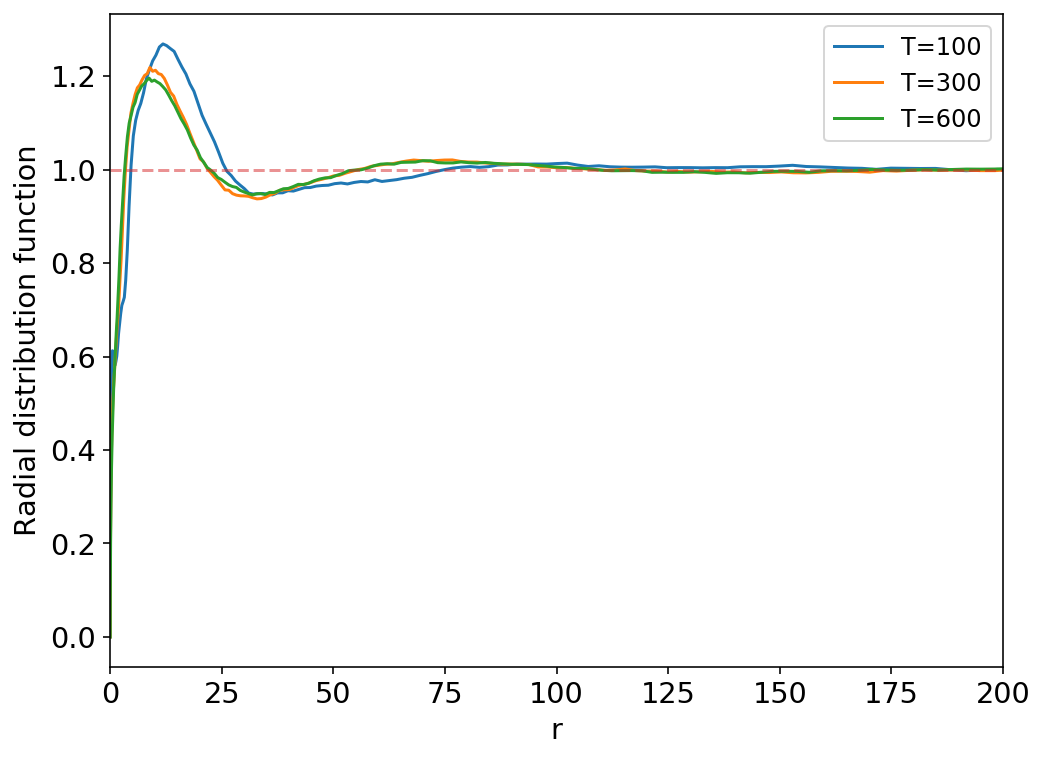

In [101]:
temps = ['100', '300', '600']

for T in temps:
    r, g = rdf('./task_m/rdf/time_avg_rdf_T' + T + '.txt')
    plt.plot(r, g, label=f'T={T}')
    plt.xlabel('r')
    plt.ylabel('Radial distribution function')
    plt.legend()
plt.xlim(0,200)
plt.plot(r, np.ones(len(r)), '--', alpha=0.5)
plt.show()

Considering the phase transition shown in the previous plots we would expect the rdf to look different. We would expect the figure for $T=100$ and $T=300$ to be less smoothed out, the former more so than the latter. Looking at the plot for the diffusion constant, we observe that it is linear between the phase transitions, which tells us that there is an increase in the msd for all states. However, we are only considering a small portion of the bulk so we cannot expect to observe the same properties as if we were considering the bulk. Below is a plot of the rdf for temperature extremes at $T=1$ K and $T=2000$ K. $T=1$ shows a behaviour which is more in line with what we would expect for a solid; a sharper peak for small r and oscillation around 1 where the other temperatures above has converged. $T=2000$ K shows the same behaviour as for $T=300$ and $T=600$ K.

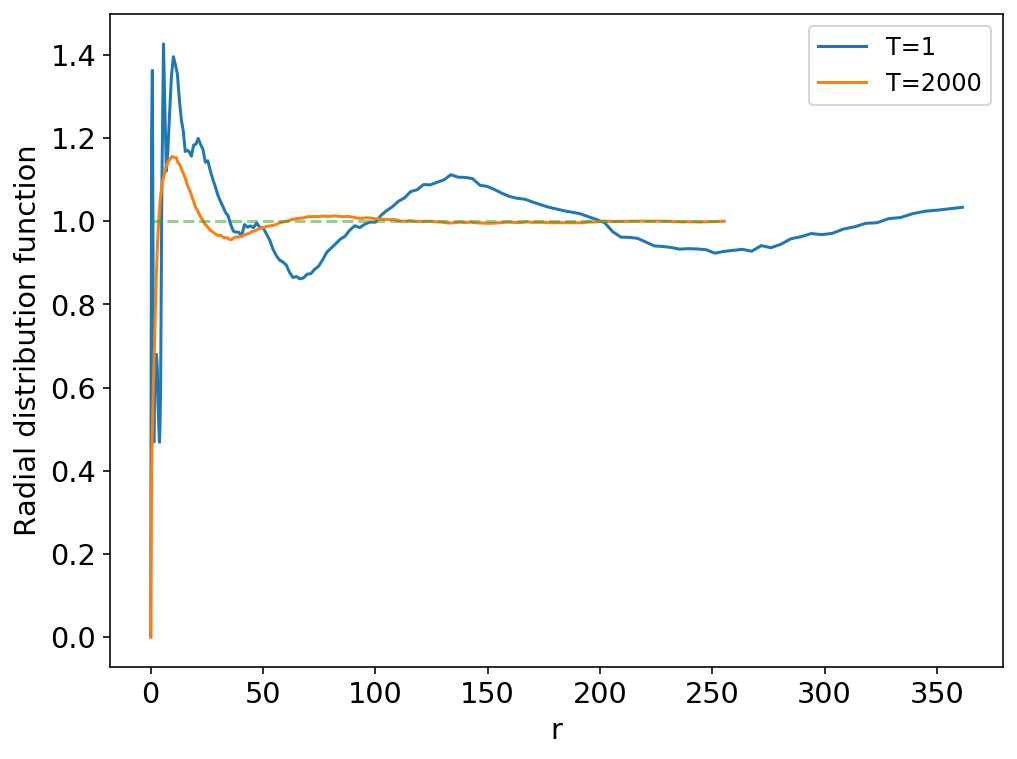

In [102]:
temps = ['1', '2000']

for T in temps:
    r, g = rdf('./task_m/rdf/time_avg_rdf_T' + T + '.txt')
    plt.plot(r, g, label=f'T={T}')
    plt.xlabel('r')
    plt.ylabel('Radial distribution function')
    plt.legend()
plt.plot(r, np.ones(len(r)), '--', alpha=0.5)
plt.show()